In [104]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder


In [105]:
# Load the dataset
file_path = r'cybersecurity_attacks.csv'
pd.set_option('display.max_columns', None)
data = pd.read_csv(file_path)

# Display basic information
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               40000 non-null  object 
 1   Source IP Address       40000 non-null  object 
 2   Destination IP Address  40000 non-null  object 
 3   Source Port             40000 non-null  int64  
 4   Destination Port        40000 non-null  int64  
 5   Protocol                40000 non-null  object 
 6   Packet Length           40000 non-null  int64  
 7   Packet Type             40000 non-null  object 
 8   Traffic Type            40000 non-null  object 
 9   Payload Data            40000 non-null  object 
 10  Malware Indicators      20000 non-null  object 
 11  Anomaly Scores          40000 non-null  float64
 12  Alerts/Warnings         19933 non-null  object 
 13  Attack Type             40000 non-null  object 
 14  Attack Signature        40000 non-null

In [106]:
data.head(4)

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,NaN,15.79,Alert Triggered,Malware,Known Pattern B,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall


In [107]:
data.fillna("No Data", inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               40000 non-null  object 
 1   Source IP Address       40000 non-null  object 
 2   Destination IP Address  40000 non-null  object 
 3   Source Port             40000 non-null  int64  
 4   Destination Port        40000 non-null  int64  
 5   Protocol                40000 non-null  object 
 6   Packet Length           40000 non-null  int64  
 7   Packet Type             40000 non-null  object 
 8   Traffic Type            40000 non-null  object 
 9   Payload Data            40000 non-null  object 
 10  Malware Indicators      40000 non-null  object 
 11  Anomaly Scores          40000 non-null  float64
 12  Alerts/Warnings         40000 non-null  object 
 13  Attack Type             40000 non-null  object 
 14  Attack Signature        40000 non-null

## Feature Engineering

In [108]:
# Convert timestamp column to datetime format
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Extracting time-based features
data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
data['Month'] = data['Timestamp'].dt.month
data['Year'] = data['Timestamp'].dt.year

# Remove duplicate records
data = data.drop_duplicates()
data.head(3)

# tranfrom "Severity Level" to numeric value
severity_mapping = {"Low" : 1, "Medium" : 2, "High" : 3}
data["Severity level in numeric"] = data["Severity Level"].map(severity_mapping)

# Create a new column named "Browser" by extracting from columns "Device Information"
data["Browser"] = data["Device Information"].str.split("/").str[0]
data["Browser"].value_counts()

# Function to extract OS type
def extract_os(user_agent):
    user_agent = user_agent.lower()
    if "windows" in user_agent:
        return "Windows"
    elif "mac os" in user_agent or "macintosh" in user_agent:
        return "MacOS"
    elif "linux" in user_agent:
        return "Linux"
    elif "android" in user_agent:
        return "Android"
    elif "iphone" in user_agent or "ipad" in user_agent:
        return "iOS"
    else:
        return "Other"

# Apply functions to extract Browser & OS
data['Operating System'] = data['Device Information'].apply(extract_os)




# Creating new features
private_ip_ranges = [10, 172, 192]
data['Is Source Private'] = data['Source IP Address'].apply(lambda x: int(x.split('.')[0]) in private_ip_ranges).astype(int)
data['Is Destination Private'] = data['Destination IP Address'].apply(lambda x: int(x.split('.')[0]) in private_ip_ranges).astype(int)



# Convert ports to categorical types
def categorize_port(port):
    if port <= 1023:
        return "Well-known"
    elif port <= 49151:
        return "Registered"
    else:
        return "Dynamic"

data['Source Port Category'] = data['Source Port'].apply(categorize_port)
data['Destination Port Category'] = data['Destination Port'].apply(categorize_port)



# Create new time-based features
data['Is Night Traffic'] = ((data['Hour'] >= 18) | (data['Hour'] <= 6)).astype(int)
data['Is Weekend'] = data['DayOfWeek'].isin([6, 7]).astype(int)


print(data.info())
data.head(5)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Timestamp                  40000 non-null  datetime64[ns]
 1   Source IP Address          40000 non-null  object        
 2   Destination IP Address     40000 non-null  object        
 3   Source Port                40000 non-null  int64         
 4   Destination Port           40000 non-null  int64         
 5   Protocol                   40000 non-null  object        
 6   Packet Length              40000 non-null  int64         
 7   Packet Type                40000 non-null  object        
 8   Traffic Type               40000 non-null  object        
 9   Payload Data               40000 non-null  object        
 10  Malware Indicators         40000 non-null  object        
 11  Anomaly Scores             40000 non-null  float64       
 12  Aler

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source,Hour,DayOfWeek,Month,Year,Severity level in numeric,Browser,Operating System,Is Source Private,Is Destination Private,Source Port Category,Destination Port Category,Is Night Traffic,Is Weekend
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,No Data,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,No Data,Server,6,1,5,2023,1,Mozilla,Windows,0,0,Registered,Registered,1,0
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,No Data,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",No Data,Log Data,No Data,Firewall,7,2,8,2020,1,Mozilla,Windows,0,0,Registered,Registered,0,0
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,2022,1,Mozilla,Windows,0,0,Registered,Dynamic,0,1
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,No Data,15.79,Alert Triggered,Malware,Known Pattern B,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",No Data,No Data,Alert Data,Firewall,10,6,7,2023,2,Mozilla,MacOS,0,0,Registered,Registered,0,1
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,No Data,0.52,Alert Triggered,DDoS,Known Pattern B,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,No Data,Alert Data,Firewall,13,6,7,2023,1,Mozilla,Windows,0,0,Registered,Registered,0,1


## Machine Learning Models

### XGBoost

In [109]:
# Attack Type is distributed evenly
data["Attack Type"].value_counts()

DDoS         13428
Malware      13307
Intrusion    13265
Name: Attack Type, dtype: int64

In [110]:
# Map "Attack Type" to numeric value
attack_type_mapping = {"DDoS" : 0,"Malware" : 1, "Intrusion" : 2}
data["Attack Type Numeric"] = data["Attack Type"].map(attack_type_mapping)

In [111]:
data.head(1)

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source,Hour,DayOfWeek,Month,Year,Severity level in numeric,Browser,Operating System,Is Source Private,Is Destination Private,Source Port Category,Destination Port Category,Is Night Traffic,Is Weekend,Attack Type Numeric
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,No Data,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,No Data,Server,6,1,5,2023,1,Mozilla,Windows,0,0,Registered,Registered,1,0,1


In [112]:
data.columns

Index(['Timestamp', 'Source IP Address', 'Destination IP Address',
       'Source Port', 'Destination Port', 'Protocol', 'Packet Length',
       'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators',
       'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature',
       'Action Taken', 'Severity Level', 'User Information',
       'Device Information', 'Network Segment', 'Geo-location Data',
       'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source',
       'Hour', 'DayOfWeek', 'Month', 'Year', 'Severity level in numeric',
       'Browser', 'Operating System', 'Is Source Private',
       'Is Destination Private', 'Source Port Category',
       'Destination Port Category', 'Is Night Traffic', 'Is Weekend',
       'Attack Type Numeric'],
      dtype='object')

In [113]:
data.head(1)

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source,Hour,DayOfWeek,Month,Year,Severity level in numeric,Browser,Operating System,Is Source Private,Is Destination Private,Source Port Category,Destination Port Category,Is Night Traffic,Is Weekend,Attack Type Numeric
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,No Data,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,No Data,Server,6,1,5,2023,1,Mozilla,Windows,0,0,Registered,Registered,1,0,1


In [114]:
selected_columns = ["Protocol", "Packet Length","Packet Type","Traffic Type","Malware Indicators",
                    "Anomaly Scores","Alerts/Warnings","Attack Signature","Action Taken",
                    "Network Segment","Firewall Logs","IDS/IPS Alerts","Log Source","Hour","DayOfWeek","Month",
                    "Year","Severity Level","Browser","Operating System","Is Source Private","Is Destination Private",
                    "Source Port Category","Destination Port Category","Is Night Traffic","Is Weekend"]



# One Hot Encoding for all categorical data

# Identify categorical columns
categorical_columns =  ["Protocol", "Packet Type","Traffic Type","Malware Indicators",
                    "Alerts/Warnings","Attack Signature","Action Taken",
                    "Network Segment","Firewall Logs","IDS/IPS Alerts","Log Source","Severity Level",
                    "Browser","Operating System",
                    "Source Port Category","Destination Port Category"]

# Instantiate OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
# Fit and transform categorical columns
encoded_array = encoder.fit_transform(data[categorical_columns])
encoded_array


array([[1., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [115]:
# Convert encoded_array to a DataFrame with clear column names
encoded_df = pd.DataFrame(encoded_array, 
                          columns=encoder.get_feature_names_out(categorical_columns),
                          index=data.index)


In [116]:

# Concatenate with the original DataFrame (excluding original categorical columns)
data_encoded = pd.concat([data[selected_columns].drop(categorical_columns, axis=1).reset_index(drop=True), 
                          encoded_df.reset_index(drop=True)], axis=1)



In [117]:
X = data_encoded
y = data["Attack Type Numeric"]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 22, stratify= y)

#  Define Hyperparameter Grid for Tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [3, 6, 9],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.2],  # Step size for updating trees
    'subsample': [0.7, 0.8, 1.0],  # Fraction of samples used per tree
    'colsample_bytree': [0.7, 0.8, 1.0],  # Fraction of features per tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction needed to make a split
    'reg_lambda': [0, 1, 10]  # L2 regularization (prevents overfitting)
}


In [118]:

# Initialize and Train the XGBoost Model
xgb_model = xgb.XGBClassifier(
    objective = "multi:softmax",
    num_class = len(y.unique()),
    eval_metric = "mlogloss",
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 6,
    tree_method = "hist",
    enable_categorical = True,
    random_state = 42
)



In [ ]:

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of random combinations to try
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=1 
)


print("\n Running Randomized Search for Hyperparameter Tuning...")
random_search.fit(X_train, y_train)



 Running Randomized Search for Hyperparameter Tuning...


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric='mlogloss', gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.1, max_bin=N...
                                           num_class=3, num_parallel_tree=None,
                                           objective='mult

In [120]:

#  Train XGBoost Model with Best Parameters
best_params = random_search.best_params_
print("\n Best Hyperparameters Found:", best_params)

xgb_model_optimized = xgb.XGBClassifier(
    **best_params,
    objective="multi:softmax",
    num_class=len(np.unique(y)),
    eval_metric="mlogloss",
    tree_method="hist",
    enable_categorical=True,
    random_state=42
)

print("\ Training Optimized XGBoost Model...")
xgb_model_optimized.fit(X_train, y_train)

#Model Evaluation
y_pred = xgb_model_optimized.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

# Print Model Performance
print("\n Optimized Model Evaluation Metrics:")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f" F1-Score: {f1:.4f}")


 Best Hyperparameters Found: {'subsample': 0.7, 'reg_lambda': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
\ Training Optimized XGBoost Model...

 Optimized Model Evaluation Metrics:
 Accuracy: 0.3351
 Precision: 0.3346
Recall: 0.3351
 F1-Score: 0.3321


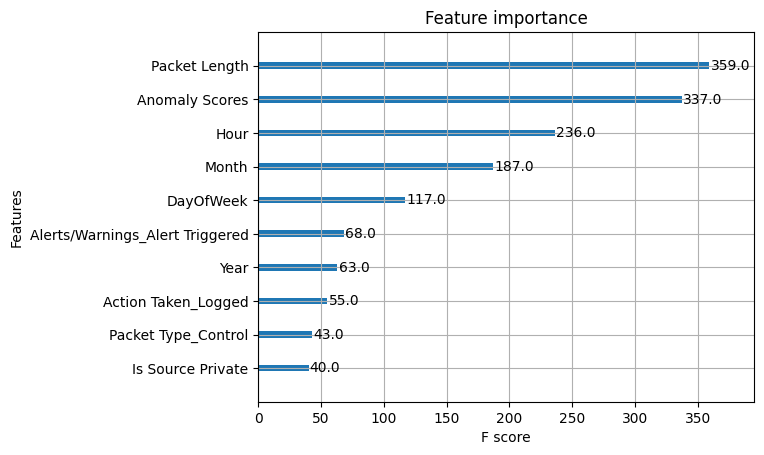

['xgb_model_optimized_model.pkl']

In [125]:
xgb.plot_importance(xgb_model_optimized, max_num_features=10)
plt.show()

import joblib

# Assuming 'model' is your trained scikit-learn model
joblib.dump(xgb_model_optimized, "xgb_model_optimized_model.pkl")



In [134]:
# Re-train the model with 5 importance features, with best parameters

X = data_encoded[["Packet Length", "Anomaly Scores", "Hour","Month","DayOfWeek","Alerts/Warnings_Alert Triggered",
                  "Year","Action Taken_Logged","Packet Type_Control","Is Source Private"]]
y = data["Attack Type Numeric"]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 22, stratify= y)

# Initialize and Train the XGBoost Model
xgb_model_optimized = xgb.XGBClassifier(
    **best_params,
    objective="multi:softmax",
    num_class=len(np.unique(y)),
    eval_metric="mlogloss",
    tree_method="hist",
    enable_categorical=True,
    random_state=42
)

print("\ Training Optimized XGBoost Model...")
xgb_model_optimized.fit(X_train, y_train)

#Model Evaluation
y_pred = xgb_model_optimized.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

# Print Model Performance
print("\n Optimized Model Evaluation Metrics:")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f" F1-Score: {f1:.4f}")




\ Training Optimized XGBoost Model...

 Optimized Model Evaluation Metrics:
 Accuracy: 0.3359
 Precision: 0.3355
Recall: 0.3359
 F1-Score: 0.3337


### Random Forest

In [127]:
rf_model = RandomForestClassifier(
    n_estimators=200,  
    max_depth=10,  
    random_state=42
)

rf_model.fit(X_train, y_train)

feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print(importance_df[0:10])
#  Model Evaluation
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

#  Print Evaluation Metrics
print("Model Evaluation Metrics:")
print("\n Classification Report:\n", classification_report(y_test, y_pred))

                  Feature  Importance
0           Packet Length    0.118634
1          Anomaly Scores    0.117798
2                    Hour    0.074615
4                   Month    0.064148
3               DayOfWeek    0.049479
5                    Year    0.035071
10          Protocol_ICMP    0.014691
36    Severity Level_High    0.014506
38  Severity Level_Medium    0.014421
12           Protocol_UDP    0.014366
Model Evaluation Metrics:

 Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.41      0.37      2620
           1       0.34      0.33      0.33      2701
           2       0.33      0.26      0.29      2679

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



### Multi Logistic Regression


In [123]:

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Define model and parameters
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l2', 'none'],  
}

# Setup GridSearchCV
grid = GridSearchCV(model, param_grid, cv=5, verbose=1, scoring='accuracy')
grid.fit(X_train, y_train)

# Best model result
print("Best parameters:", grid.best_params_)
print("Best cross-validation score: {:.3f}".format(grid.best_score_))

# Test set evaluation
test_accuracy = grid.score(X_test, y_test)
print("Test set accuracy: {:.3f}".format(test_accuracy))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\nguye\anaconda3\envs\mlproject\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
c:\Users\nguye\anaconda3\envs\mlproject\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
c:\Users\nguye\anaconda3\envs\mlproject\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
c:\Users\nguye\anaconda3\envs\mlproject\lib\site-packages\sklearn\linear_model\_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
c:\Users\nguye\anaco

Best parameters: {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}
Best cross-validation score: 0.335
Test set accuracy: 0.334


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from tensorflow.keras.layers import Conv1D, Flatten, MaxPooling1D,Dense, Dropout
from tensorflow.keras.models import Sequential

cnn_model = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1), y_train, epochs=25, batch_size=32, validation_data=(X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1), y_test))

Epoch 1/100
 656/1000 [==================>...........] - ETA: 3s - loss: 1.0998 - accuracy: 0.3302

KeyboardInterrupt: 